# Goal

This notebook selects a subset of data to use as training data.

Available MR data from:
- ABIDE.txt (1160 files)
- ABVIB.txt (778 files)
- ACRIN-FMISO-Brain.txt (1403 files)
- ADNI.txt (2640 files)
- PPMI.txt (1524 files)

In [61]:
import os
import time
import pickle
from pathlib import Path

import SimpleITK as sitk

import numpy as np
from pandas import DataFrame as DF

from helpers_general import sitk2np, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups

In [37]:
# wsl: /home/rgologorsky/DeepPit
hd_path = "../../../mnt/d/PitMRdata"

# all folders in HD
all_folders = os.listdir(hd_path)

# folders with data
data_folders = ["ABIDE", "ABVIB", "ACRIN-FMISO-Brain", "ADNI", "PPMI"]

# get paths to MR
mr_paths = []

for folder in data_folders:
    with open(f"{folder}.txt", "rb") as fp:   # Unpickling
        mr_paths.append(pickle.load(fp))

# Input selection

In [49]:
# number of paths in each data folder
lens = [len(d) for d in mr_paths]
print(lens)

# choose n=3 MRs from each data folder
n = 3
train_paths = [np.random.choice(a, size=n, replace=False) for a in mr_paths]
print(*idxs, sep="\n")

[1160, 778, 1403, 2640, 1524]
['../../../mnt/d/PitMRdata/ABIDE/ABIDE/50970/MP-RAGE/2000-01-01_00_00_00.0/S165390'
 '../../../mnt/d/PitMRdata/ABIDE/ABIDE_1/50452/MP-RAGE/2000-01-01_00_00_00.0/S164660'
 '../../../mnt/d/PitMRdata/ABIDE/ABIDE_1/50197/MP-RAGE/2000-01-01_00_00_00.0/S165318']
['../../../mnt/d/PitMRdata/ABVIB/ABVIB/59008/t2_tse3dvfl_sag_st2_p2/2012-04-18_12_56_58.0/S342077'
 '../../../mnt/d/PitMRdata/ABVIB/ABVIB/227/t1_mpr_sag-WS/2010-12-20_16_44_42.0/S349219'
 '../../../mnt/d/PitMRdata/ABVIB/ABVIB/3619/MPRAGE/2011-05-12_14_33_59.0/S341048']
['../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-006/09-14-1960-MRIBRNWWO3DWRPER-87904/4.000000-Ax DIFFUSIONADC-89552'
 '../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-003/10-04-1960-87653/5.000000-FLAIR mosaic-09370'
 '../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-003/03-14-1960-44600/12.000000-FLAIR mosaic-63085']
['../../../mnt/d/PitMRdata/ADNI/ADNI1_Annual_2_Yr_3T/002_S_1070/MPR____N3__Scaled/

# Metadata

In [58]:
# data src2idx
src2idx = dict((v,k) for k,v in enumerate(data_folders))


flat_train_paths = [p for a in train_paths for p in a]
#print(f"Train sz = {len(flat_train_paths)}:", *flat_train_paths, sep="\n")

def get_folder_name(s):
    s = s[len("../../../mnt/d/PitMRdata/"):]
    return s[0:s.index("/")]

# get extension
# assume all files in dir have same extension
def get_ext(dir_path):
    # assume all files in dir have same extension
    file = next(os.walk(dir_path))[2][0]
    
    # in case file is bytes not str
    try:
        file = file.decode()
    except:
        pass
    
    return Path(file).suffix.lower()

# data frame w/ meta data info
d = [None] * len(flat_train_paths)

for i,path in enumerate(flat_train_paths):
    
    # get folder name = data src
    folder = get_folder_name(path)
    
    # get file ext (nii, dcm, etc)
    idx    = src2idx[folder]
    ext    = get_ext(path)
    
    # get file
    # ASSUMES only 1 nii in folder
    
    if ext == ".nii" or ext == ".dcm":
        file = os.listdir(str(path))[0]
        file = f"{path}/{file}"
    else:
        print(f"Weird ext - {ext}.")
    
    # read meta data
    reader = sitk.ImageFileReader()
    reader.SetFileName(file)
    reader.ReadImageInformation()
    
    d[i] = {
        "folder": folder,
        "fn":  file,
        "sz": reader.GetSize(),
        "px": sitk.GetPixelIDValueAsString(reader.GetPixelID()),
        "sp": tuple(round(x,2) for x in reader.GetSpacing()),
        "dir": tuple(int(round(x,1)) for x in reader.GetDirection())
    }
    
d = DF(d)
d

,folder,fn,sz,px,sp,dir
0,ABIDE,../../../mnt/d/PitMRdata/ABIDE/ABIDE/50972/MP-...,"(128, 256, 256)",16-bit signed integer,"(1.33, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
1,ABIDE,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51359/MP-...,"(144, 240, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
2,ABIDE,../../../mnt/d/PitMRdata/ABIDE/ABIDE/51313/Mat...,"(128, 128, 34)",16-bit signed integer,"(1.5, 1.5, 4.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
3,ABVIB,../../../mnt/d/PitMRdata/ABVIB/ABVIB/60006/MPR...,"(256, 256, 1)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
4,ABVIB,../../../mnt/d/PitMRdata/ABVIB/ABVIB/7002/T1_S...,"(256, 256, 1)",16-bit signed integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
5,ABVIB,../../../mnt/d/PitMRdata/ABVIB/ABVIB/251/MPRAG...,"(256, 256, 1)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 0, 0, 0, 0, 0, 0)"
6,ACRIN-FMISO-Brain,../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACR...,"(256, 256, 1)",16-bit signed integer,"(0.94, 0.94, 5.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
7,ACRIN-FMISO-Brain,../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACR...,"(512, 512, 1)",64-bit float,"(0.44, 0.44, 5.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
8,ACRIN-FMISO-Brain,../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACR...,"(512, 512, 1)",16-bit signed integer,"(0.49, 0.49, 3.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
9,ADNI,../../../mnt/d/PitMRdata/ADNI/ADNI1_Complete_1...,"(256, 256, 166)",32-bit float,"(0.94, 0.94, 1.2)","(0, 0, 1, 0, 1, 0, -1, 0, 0)"


# Standard Reference Domain

In [63]:
def get_img_data(path):
    # get folder name = data src
    folder = get_folder_name(path)
    
    # get file ext (nii, dcm, etc)
    idx    = src2idx[folder]
    ext    = get_ext(path)
    
    # get file
    # ASSUMES only 1 nii in folder
    
    if ext == ".nii" or ext == ".dcm":
        file = os.listdir(str(path))[0]
        file = f"{path}/{file}"
    else:
        print(f"Weird ext - {ext}.")
        
    reader = sitk.ImageFileReader()
    reader.SetFileName(file)
    reader.ReadImageInformation()
    return  reader.GetSize(), reader.GetSpacing() #reader.GetDirection()

# Relevant data to create standard reference frame
all_img_data = [get_img_data(path) for path in flat_train_paths]

def get_reference_frame(all_img_data):
    img_data = all_img_data
    
    dimension = 3 # 3D MRs
    pixel_id = 2 # 16-bit signed integer

    # Physical image size corresponds to the largest physical size in the training set, or any other arbitrary size.
    reference_physical_size = np.zeros(dimension)

    for img_sz, img_spc in img_data:
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx else mx \
                                      for sz, spc, mx in zip(img_sz, img_spc, reference_physical_size)]
    
    # Create the reference image with a zero origin, identity direction cosine matrix and dimension     
    reference_origin = np.zeros(dimension)
    reference_direction = np.identity(dimension).flatten()

    # Isotropic (1,1,1) pixels
    reference_spacing = np.ones(dimension)
    reference_size = [int(phys_sz/(spc) + 1) for phys_sz,spc in zip(reference_physical_size, reference_spacing)]

    # Set reference image attributes
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)

    reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))
    return reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center

def get_reference_image(reference_frame):
    reference_size, pixel_id, reference_origin, reference_spacing, reference_direction, reference_center = reference_frame
    reference_image = sitk.Image(reference_size, pixel_id)
    reference_image.SetOrigin(reference_origin)
    reference_image.SetSpacing(reference_spacing)
    reference_image.SetDirection(reference_direction)
    return reference_image, reference_center

# Get reference frame
reference_frame = get_reference_frame(all_img_data)
print("Reference frame: ", *reference_frame)

# Get reference image
reference_image, reference_center = get_reference_image(reference_frame)
print("Reference center: ", reference_center)

# Print info on reference image
print_sitk_info(reference_image)

Reference frame:  [266, 266, 256] 2 [0. 0. 0.] [1. 1. 1.] [1. 0. 0. 0. 1. 0. 0. 0. 1.] [133. 133. 128.]
Reference center:  [133. 133. 128.]
Size:  (266, 266, 256)
Origin:  (0.0, 0.0, 0.0)
Spacing:  (1.0, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer


# Input + Tfms

In [123]:
# removed mask arg
def resample2ref(img, reference_image, reference_center, interpolator = sitk.sitkLinear, default_intensity_value = 0.0, dimension=3):
    
    # Define translation transform mapping origins from reference_image to the current img
    transform = sitk.AffineTransform(dimension)
    transform.SetMatrix(img.GetDirection())
    transform.SetTranslation(np.array(img.GetOrigin()) - reference_image.GetOrigin())
    
    # Modify the transformation to align the centers of the original and reference image instead of their origins.
    centering_transform = sitk.TranslationTransform(dimension)
    img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
    centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
    centered_transform = sitk.Transform(transform)
    centered_transform.AddTransform(centering_transform)
    
    return sitk.Resample(img, reference_image, centered_transform, interpolator, default_intensity_value, o.GetPixelID())

In [111]:
def get_img(path):
    # get folder name = data src
    folder = get_folder_name(path)
    
    # get file ext (nii, dcm, etc)
    idx    = src2idx[folder]
    ext    = get_ext(path)
    
    # get file
    # ASSUMES only 1 nii in folder
    
    if ext == ".nii":
        file = os.listdir(str(path))[0]
        file = f"{path}/{file}"
        return sitk.ReadImage(file, sitk.sitkFloat32)

    elif ext == ".dcm":
        reader = sitk.ImageSeriesReader()
        dicom_names = reader.GetGDCMSeriesFileNames(str(path))
        reader.SetFileNames(dicom_names)
        return reader.Execute()

    else:
        print(f"Weird ext - {ext}.")

In [112]:
train_paths[2][0]

'../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-008/03-08-1960-RA MRI BRAIN WITH WITHOUT CONTRAST-45355/5.000000-Ax DIFFUSION HIRES-93315'

In [113]:
o = get_img(train_paths[2][0])

In [114]:
print_sitk_info(o)

Size:  (256, 256, 210)
Origin:  (-118.379, -144.752, -47.0138)
Spacing:  (0.9375, 0.9375, 0.69377990430622)
Direction:  (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 2 = 16-bit signed integer


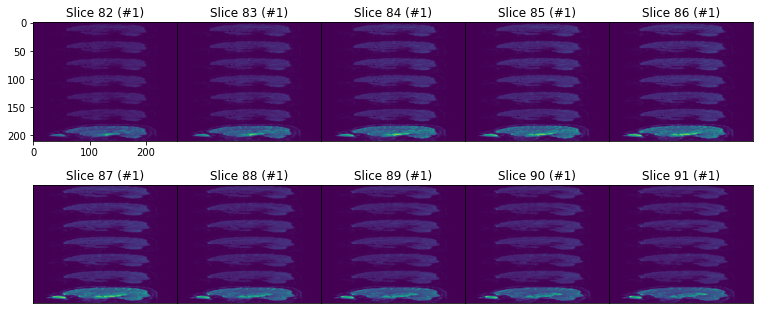

In [115]:
# viz
# Row 1 = resampled img obj, resampled mask obj
viz_axis(np_arr = sitk2np(o), \
        slices=lrange(82,92), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [118]:
# reorient to LPI by default
oo = reorient(o)

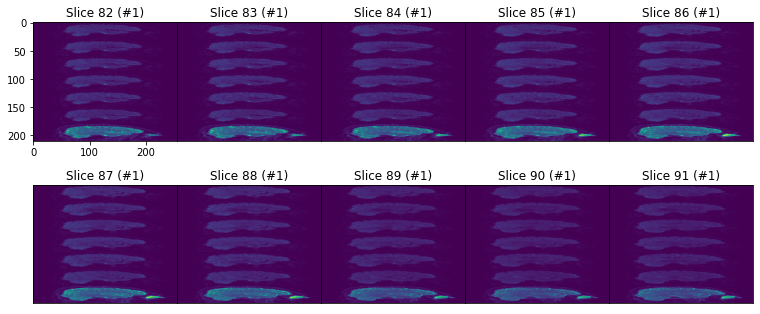

In [119]:
# viz
# Row 1 = resampled img obj, resampled mask obj
viz_axis(np_arr = sitk2np(oo), \
        slices=lrange(82,92), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

In [124]:
ooo = resample2ref(o, reference_image, reference_center)

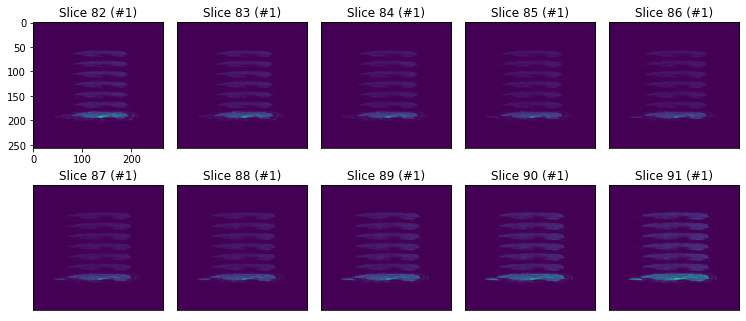

In [128]:
# viz
# Row 1 = resampled img obj, resampled mask obj
viz_axis(np_arr = sitk2np(ooo), \
        slices=lrange(82,92), fixed_axis=0, \
        axis_fn = np.rot90, \
        grid = [2, 5], hspace=0.3, fig_mult=2)

# Normal

In [129]:
train_paths

[array(['../../../mnt/d/PitMRdata/ABIDE/ABIDE/50972/MP-RAGE/2000-01-01_00_00_00.0/S165374',
        '../../../mnt/d/PitMRdata/ABIDE/ABIDE/51359/MP-RAGE/2000-01-01_00_00_00.0/S164648',
        '../../../mnt/d/PitMRdata/ABIDE/ABIDE/51313/Matched_Bandwidth_Hires/2000-01-01_00_00_00.0/S162855'],
       dtype='<U96'),
 array(['../../../mnt/d/PitMRdata/ABVIB/ABVIB/60006/MPRAGE/2012-05-02_10_34_17.0/S342260',
        '../../../mnt/d/PitMRdata/ABVIB/ABVIB/7002/T1_SPGR/2012-07-09_12_12_56.0/S350658',
        '../../../mnt/d/PitMRdata/ABVIB/ABVIB/251/MPRAGE/2011-07-07_11_25_29.0/S343471'],
       dtype='<U102'),
 array(['../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-008/03-08-1960-RA MRI BRAIN WITH WITHOUT CONTRAST-45355/5.000000-Ax DIFFUSION HIRES-93315',
        '../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-001/06-09-1963-MRI BRAIN WOW CONT-56825/501.000000-AX T1 SE-46251',
        '../../../mnt/d/PitMRdata/ACRIN-FMISO-Brain/ACRIN-FMISO-Brain-008/03-08-1960-RA MR

In [132]:
def viz_lps_hd():
    o = get_img(train_paths[0][0])

    print_sitk_info(o)

    # viz
    # Row 1 = resampled img obj, resampled mask obj
    viz_axis(np_arr = sitk2np(o), \
            slices=lrange(82,92), fixed_axis=0, \
            axis_fn = np.rot90, \
            grid = [2, 5], hspace=0.3, fig_mult=2)

    # reorient to LPI by default
    oo = reorient(o)

    # viz
    # Row 1 = resampled img obj, resampled mask obj
    viz_axis(np_arr = sitk2np(oo), \
            slices=lrange(82,92), fixed_axis=0, \
            axis_fn = np.rot90, \
            grid = [2, 5], hspace=0.3, fig_mult=2)

    ooo = resample2ref(o, reference_image, reference_center)

    # viz
    # Row 1 = resampled img obj, resampled mask obj
    viz_axis(np_arr = sitk2np(ooo), \
            slices=lrange(82,92), fixed_axis=0, \
            axis_fn = np.rot90, \
            grid = [2, 5], hspace=0.3, fig_mult=2)



Size:  (128, 256, 256)
Origin:  (-84.45523071289062, 127.0, -127.0)
Spacing:  (1.3300018310546875, 1.0, 1.0)
Direction:  (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
Pixel type: 8 = 32-bit float


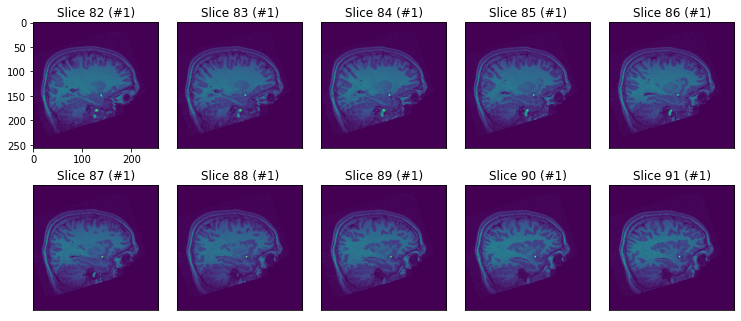

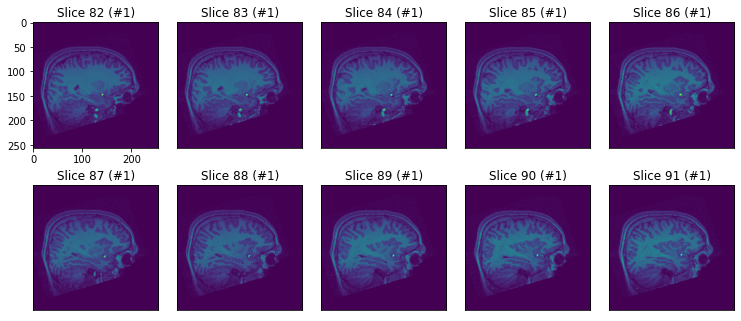

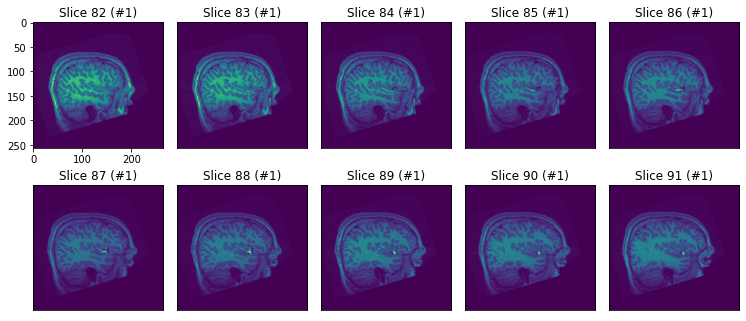

In [133]:
viz_lps_hd()